# Train your own predictor

This notebook is for when you want to train your own age predictor on new data in your possession.

Requirements: Gene expression data collected in a single batch on a single platform, or maybe data you have batch corrected from multiple batches.  I ran this originally on FPKM, TPM, and raw counts and it worked just fine in all of these but in my batch/pipeline setup worked a few percent better in FPKM. I also believe that you will not get very good results unless you have a couple of dozen samples that span an age range of 0 - 80ish years with a relatively even distribution of subjects per decade.  Training on datasets with ~20 subjects from 20-60 years old didn't work very well.  It's the usual: more training set data, and balanced data that covers all possible cases of interest, produces better generalization when predicting.

This notebook requires versions of the following libraries that are at least as recent as:
* Jupyter notebook 5.0.0
* Python 2.7.9
* Pandas 0.22
* Scipy 0.19
* Matplotlib 2.1.0
* Seaborn 0.7.1

NOTE: This notebook has been updated to work correctly with python 3.X

In [1]:
%run age_predictors.py

Here's where you can define your own function that is suitable for loading your data in a format that works with this software

Requirements: Output data needs to be in a pandas Dataframe that contains a row for every sample and a column for every expression value.  The index of the dataframe should include a column 'UID' that uniquely identifies each sample, a column 'age' that expresses the subjects age in years, and a column 'meta' that holds metadata you might want to keep track of for a later analysis.  Column header must have a unique label for each column; the exact nature of that header is up to you... use Refseq or whatever you feel like as long as its unique per column.  The columns (the expression data) is similarly up to you: you can feed the system every isoform or sum-of-all-isoforms-per-gene or top-expressing-isoforms-per-gene... the last one is what we used in the paper, but the others were tried as well and did just a few percent worse at prediction. Likewise you can choose your preferred quantification/normalization, I have tested the system with FPKM, TPM, and raw counts, and it works just fine with all of these.    

This implementation assumes that the data will come from a file organized just like it says above: 

| UID     | age | meta |  transcript1 | transcript2 |   |
|---------|-----|------|-------|-------------|---|
| sample1 | 11  | healthy | ...   | ...         |   |
| sample2 | 13  | progeria | ...  | ..          |   |

but if you have a file that is the opposite setup, that is rows are transcripts and columns are samples, then just set the argument transpose=True when you call load data.

This function will load comma seperated or xlsx files according to the ending of filename variable.

Feel free to modify this function to better fit the file format you prefer to use!



In [2]:
def load_data(filename, transpose=False):
    
    ending = filename.split('.')[-1]
    
    if ending == 'csv':
        data = pd.read_csv(filename,header=None,index_col=None)
    elif ending == 'xlsx':
        data = pd.read_xlsx(filename,header=None,index_col=None)
    else:
        raise TypeError('dont know what file type this is')
    
    if transpose:
        data = data.T
    
    # make sure the index columns are named correctly, 
    # otherwise use whatever the first row (header) contains for gene/transcript names
    cols = data.iloc[0,:]
    cols[0] = 'uid'
    cols[1] = 'age'
    cols[2] = 'meta'
    data.columns = cols
    
    # get the data, not the header now that we formed it
    data = data.iloc[1:,:]
    
    # make sure the age comes in as integer years... if you need to do floating point change this
    data.iloc[:,1] = data.iloc[:,1].astype(int)
    
    data = data.set_index(['uid','age','meta']).astype(float)
    
    return data



In [3]:
# this won't work if you don't point this function at your data :)

#data = load_data('gene_labelled_data.csv')
data = load_data('binary_gene_labels.csv')

In [4]:
data

,,,KCNA4>PEG3,CAV2>SGMS1,LINC01819>LOC100506178,CADM1>CIT,C1QTNF3>HIF1A-AS1,PLPP7>LOC101927932,LOC100129534>SKP1P2,HTR1F>B4GALNT1,MORN1>ATG16L1,RGAG4>GJD3,...,RPTN>DOCK10,MCMDC2>GPR85,LAPTM5>MRPS28,MTO1>FAM49B,MIR1229>YWHAEP1,SH3RF2>ISL2,TBKBP1>C9orf85,PSMC3IP>CDKN2D,EID2B>CDKAL1,OLFML3>BMF
uid,age,meta,,,,,,,,,,,,,,,,,,,,,
22,29,normal,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
104,19,normal,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
155,22,normal,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
35,42,normal,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
61,84,normal,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,88,normal,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
94,12,normal,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
48,64,normal,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Define what kind of cross-validation you want to do... leave-one-out, k-fold, repeated k-fold, etc..  Why would you pick one or the other?  Fewer samples means you may need leave one out, or a large K fold.  Larger samples would send you towards small K.  But please read up about the bias-variance tradeoff in cross-validation :) Another consideration is that you may need to stratify your data, like if you have multiple samples from the same person you wouldn't want to train on one of their samples while testing on another. Scikit-learn has stratified cross-validators you can use for that.

You must select what kind of classifier to use inside the ensemble, and any parameters that are associated with it.  In the paper, we found that LDA worked the best on our data. LDA has only a solver parameter, you need to use "eigen" with automatic shrinkage for best results.  In my experience the best alternative classifier I've tried is Random Forest isn't usually that bad, depending on your dataset;  it also has the advantage of being several orders of magnitude faster than LDA on genomic data.  

You must also select the parameters for the ensemble.  I suggest log transforming the data, which my ensemble class can do for you with the argument (```dataxform_log=True```), for me it was generally better than raw FPKM/TPM/counts. There are other transformations you could try as well:  rank (```dataxform_rank=True```) will rank normalize expression within a sample or quantile; (```dataxform_quantile=True```) will quantile normalize within a transcript/gene across samples. 

Most importantly you will need to select the ```subset_min``` and ```subset_fold``` parameters to work best with your data. My 5/5 setting is only going to work well for my data, probably not yours.  Generally these parameters have to do two jobs: 1)  eliminate from consideration expression values that are so small in magnitude or unchanging between samples that they have little chance of signalling age; and 2) trim down the number of variables underconsideration to make LDA a reasonable undertaking.  The eigne LDA solver in sklearn (which we use for accuracy and the ability to apply a shrinkage estimator to the covariance estimate) will start to really slow down if too many variables make it through the subsetting procedure. Try to set parameters so that you get between 2,000 and 7,000 genes.  Too many and LDA will slow or even run out of memory; accuracy may also suffer.  Too few and accuracy will suffer as well.   

In the code below I have included the parameters and classifier that worked best for my dataset, they may not be the ones that will work best on yours. Feel free to change the code below as you need to.

If you are going to do parameter search to find the best ones for your data, consider usign the sklearn function GridSearchCV to do so.  The notebook "Generate figures for paper" contains an example of how to use GridSearchCV.

In [9]:
from sklearn.ensemble import RandomForestClassifier
# much faster option when you try my gene_labelled_data.csv or other large datasets would be
crossval = RepeatedKFold(n_repeats=3, n_splits=10)
#crossval = LeaveOneOut()  

# This is the setup to make an ensemble of Linear Discriminant Analyses just like in our paper
# you must use the slow eigen solver to get shrinkage if you use an LDA ensemble... 
# without shrinkage the results will be worse
# feel free to change parameters or clf to a completely different classifier for the ensemble!

# muich faster option for trying things out (with loss of predictive ability)
# crossval = KNeighborsClassifier()
#clf = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen') 
#clf = KNeighborsClassifier()
clf = RandomForestClassifier(class_weight='balanced')
#ensemble = subset_genes_ensemble(clf=clf, class_size=20, subset_fold=5,subset_min=5,dataxform_log=True,verbose=True)
#For binary xdata
ensemble = subset_genes_ensemble(clf=clf, class_size=20, subset_fold=0,subset_min=-1,dataxform_log=False,verbose=True)

iteration 0
using 130 genes in subset requiring a max FPKM > -1 and > 0-fold change between max and min samples 
CPU times: user 1.86 s, sys: 53.7 ms, total: 1.91 s
Wall time: 1.96 s
iteration 1
using 131 genes in subset requiring a max FPKM > -1 and > 0-fold change between max and min samples 
CPU times: user 1.77 s, sys: 27.1 ms, total: 1.8 s
Wall time: 1.81 s
iteration 2
using 131 genes in subset requiring a max FPKM > -1 and > 0-fold change between max and min samples 
CPU times: user 2.01 s, sys: 169 ms, total: 2.18 s
Wall time: 2.37 s
iteration 3
using 131 genes in subset requiring a max FPKM > -1 and > 0-fold change between max and min samples 
CPU times: user 1.88 s, sys: 26 ms, total: 1.9 s
Wall time: 1.91 s
iteration 4
using 130 genes in subset requiring a max FPKM > -1 and > 0-fold change between max and min samples 
CPU times: user 1.79 s, sys: 21.3 ms, total: 1.81 s
Wall time: 1.82 s
iteration 5
using 130 genes in subset requiring a max FPKM > -1 and > 0-fold change betwee

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


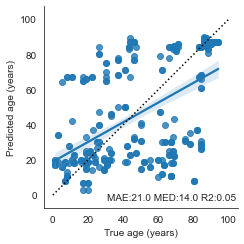

In [10]:
# OK, let's train this 
# we will be printing as we go, giving the timing information at each step 
# so you can estimate how long it will take to run this after the first few steps
# knowing the number of validation folds you setup in the crossval

ages = data.index.get_level_values('age').values
true_age = []
pred_age = []
cvit = 0

for train, test in crossval.split(data,ages):
    print('iteration {}'.format(cvit))
    cvit = cvit+1
    %time ensemble.fit(data.iloc[train,:],ages[train])
    pred_age.append( ensemble.predict(data.iloc[test,:]) )
    true_age.append( ages[test] )
    
pred = flatten(pred_age)
true = flatten(true_age)

sns.set_style('white')
fig1 = plt.figure(figsize=(3.5,3.5));
ax1 = fig1.add_subplot(111);
errstr = "MAE:{:3.1f} MED:{:3.1f} R2:{:3.2f}".format( score_MAE(true,pred), score_MED(true,pred), score_R2(true,pred)) 
sns.regplot(true,pred, ax=ax1)
ax1.plot([0,100],[0,100],'k:')
ax1.text(0.99, 0.03, errstr,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax1.transAxes)
plt.axis('equal')
ax1.set_xlabel('True age (years)'), ax1.set_ylabel('Predicted age (years)');
sns.despine()
plt.tight_layout()